# 02_01_DAOStarfinder

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, astropy, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name==version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [15]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, photutils, ccdproc, imexam, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        #print(f"**** module {pkg} is not installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module photutils is installed
**** module ccdproc is installed
**** module imexam is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2023-05-01 09:51:23 (KST = GMT+0900) 
0 Python     3.8.16 64bit [GCC 11.2.0]
1 IPython    8.8.0
2 OS         Linux 5.15.0 71 generic x86_64 with glibc2.17
3 numpy      1.22.0
4 pandas     1.5.2
5 matplotlib 3.2.0
6 scipy      1.8.1
7 astropy    5.2.1
8 photutils  1.6.0
9 ccdproc    2.4.0
10 imexam     0.9.1
11 version_information 1.0.4


### import modules

In [16]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.nddata import CCDData
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats

from photutils import DAOStarFinder
from photutils import IRAFStarFinder
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils import detect_threshold
from photutils.centroids import centroid_com
#from photutils import aperture_photometry as apphot

import warnings

from ccdproc import CCDData, ccd_process

from astropy.time import Time
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

import ysfitsutilpy as yfu
import ysphotutilpy as ypu
import ysvisutilpy as yvu

import _Python_utilities
import _astro_utilities
import _tool_visualization as vis

plt.rcParams.update({'figure.max_open_warning': 0})

/tmp/ipykernel_46069/4292205705.py:22: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/tmp/ipykernel_46069/4292205705.py:23: DeprecationWarning: `photutils.IRAFStarFinder` is a deprecated alias for `photutils.detection.IRAFStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import IRAFStarFinder` to silence this warning.
  from photutils import IRAFStarFinder
/tmp/ipykernel_46069/4292205705.py:26: DeprecationWarning: `photutils.detect_threshold` is a deprecated alias for `photutils.segmentation.detect_threshold` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_threshold` to silence this warning.
  from photutils import detect_threshold


In [17]:
#%%
#####################################################################
# Observed location
LOCATION = dict(lon = 127.0, lat = 37.3, elevation = 130)

# It is used as a rough estimate, so no need to be accurate:
PIX2ARCSEC = 0.98 * u.arcsec

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit = u.deg, frame = 'icrs')

# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5 * FWHM_INIT # Aperture radius
R_IN = 4 * FWHM_INIT   # Inner radius of annulus
R_OUT = 6 * FWHM_INIT  # Outer radius of annulus
#######################################################

In [18]:
#######################################################
# read all files in base directory for processing
BASEDIR = Path(r"r:\CCD_obs")
BASEDIR = Path("/mnt/Rdata/OBS_data") 
#BASEDIR = Path("/mnt/OBS_data") 
DOINGDIR = Path(BASEDIR/ "RnE_2022/GSON300_STF-8300M")
#DOINGDIR = Path(BASEDIR/ "CCD_new_files1")

#DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(DOINGDIR))
DOINGDIRs = sorted([x for x in DOINGDIR.iterdir() if x.is_dir()])
#print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

len(DOINGDIRs):  7


In [19]:
for DOINGDIR in DOINGDIRs[:1] :
    #DOINGDIR = Path(DOINGDIR)
    print("DOINGDIR", DOINGDIR)
    fits_in_dir = sorted(list(DOINGDIR.glob('*.fit*')))
    #print("fits_in_dir", fits_in_dir)
    print("len(fits_in_dir)", len(fits_in_dir))

    if len(fits_in_dir) == 0 :
        print(f"There is no fits fils in {DOINGDIR}")
        pass
    else : 
        print(f"Starting: {str(DOINGDIR.parts[-1])}")

        MASTERDIR = DOINGDIR / _astro_utilities.master_dir
        REDUCEDDIR = DOINGDIR / _astro_utilities.reduced_dir2
        SOLVEDDIR = DOINGDIR / _astro_utilities.solved_dir2
        DAORESULTDIR = DOINGDIR / _astro_utilities.DAOfinder_result_dir
        
        if not DAORESULTDIR.exists():
            os.makedirs("{}".format(str(DAORESULTDIR)))
            print("{} is created...".format(str(DAORESULTDIR)))

        #summary = yfu.make_summary(BASEDIR/"*.fit*")
        summary = yfu.make_summary(SOLVEDDIR/"*.fit*")

DOINGDIR /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin
len(fits_in_dir) 263
Starting: KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin
All 119 keywords (guessed from /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-10-49-48_120sec_GSON300_STF-8300M_-19C_1bin.fit) will be loaded.


/home/guitar79/anaconda3/envs/astro_Python_ubuntu_env/lib/python3.8/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key EXTEND not found for /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_r_2022-10-23-14-14-09_180sec_GSON300_STF-8300M_-20C_1bin.fit, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/anaconda3/envs/astro_Python_ubuntu_env/lib/python3.8/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key BZERO not found for /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_r_2022-10-23-14-14-09_180sec_GSON300_STF-8300M_-20C_1bin.fit, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/anaconda3/envs/astro_Python_ubuntu_env/lib/python3.8/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key HFD not found for /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-830

In [20]:
if summary.empty:
    print("The dataframe(summary) is empty")
    pass
else:
    print("len(summary):", len(summary))
    print("summary:", summary)

len(summary): 40
summary:                                                  file  filesize  SIMPLE  \
0   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
1   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
2   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
3   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
4   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
5   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
6   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
7   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
8   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
9   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
10  /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
11  /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  1703232

### Light

In [21]:
df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
df_light = df_light.reset_index(drop=True)
print("df_light:\n{}".format(df_light))from mpl_toolkits.axes_grid1 import make_axes_locatable


df_light:
                                                 file  filesize  SIMPLE  \
0   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
1   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
2   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
3   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
4   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
5   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
6   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
7   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
8   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
9   /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
10  /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
11  /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/...  17032320    True   
12 

In [22]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    print("type(fpath)", type(fpath))
    print("fpath", fpath)   

type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-10-49-48_120sec_GSON300_STF-8300M_-19C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-11-09-13_120sec_GSON300_STF-8300M_-19C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-11-15-27_120sec_GSON300_STF-8300M_-20C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-12-23-01_180sec_GSON300_STF-8300M_-19C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_dat

In [23]:
#hdul = fits.open(fpath)
#hdr = hdul[0].header
#img = hdul[0].data
#print("img: {}".format(img))
#print("img.shape: {}".format(img.shape))

ccd = CCDData.read(fpath, unit="adu")
print("ccd.data: ", ccd.data)
print("ccd.data.shape: ", ccd.data.shape)
# Set WCS and print for your information
w = ccd.wcs
print("WCS: {}".format(w))

# thresh = detect_threshold(data=img, nsigma=3)
# thresh = thresh[0][0]
# print('detect_threshold', thresh)

ccd.data:  [[17256 18940 18842 ... 13669 13780 13421]
 [17404 18790 18542 ... 13973 13930 13900]
 [16891 18850 18110 ... 14155 13495 14206]
 ...
 [16133 17494 17928 ... 12940 12760 12833]
 [16503 17401 17610 ... 12975 12794 12785]
 [16779 17720 17588 ... 12654 12600 12744]]
ccd.data.shape:  (2532, 3352)
WCS: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 340.74259274  3.94596065443  
CRPIX : 1676.5  1266.5  
CD1_1 CD1_2  : 0.000254608662294  4.52030949084e-06  
CD2_1 CD2_2  : -4.52558959506e-06  0.000254697855616  
NAXIS : 3352  2532


detect_threshold 19314.988460580214
48 star(s) founded by DAOStarFinder...
48 star(s) founded by DAOStarFinder...
 id     xcentroid          ycentroid           sharpness            roundness1            roundness2      npix sky   peak         flux                 mag         
--- ------------------ ------------------ ------------------- --------------------- --------------------- ---- --- ------- ------------------ ---------------------
  1 2589.9214059717715 230.41632353539214  0.3768604961378856    -0.232189547174687   -0.7896738653607107   49 0.0 31629.0 1.2965662317813684   -0.2819867662468274
  2 1326.1351431904307 249.49888921124224  0.3958284591678929  -0.18341033861572167   -0.5869680871092786   49 0.0 35922.0 1.4621568654678299  -0.41248491950357424
  3  2512.875820192523 363.70538649510917  0.3993755991315726  -0.19741422846024242   -0.7522128937332457   49 0.0 29748.0  1.140439805513071  -0.14268091841260477
  4 3329.0932870118686  428.8601816309924  0.4163660386740814  -0.

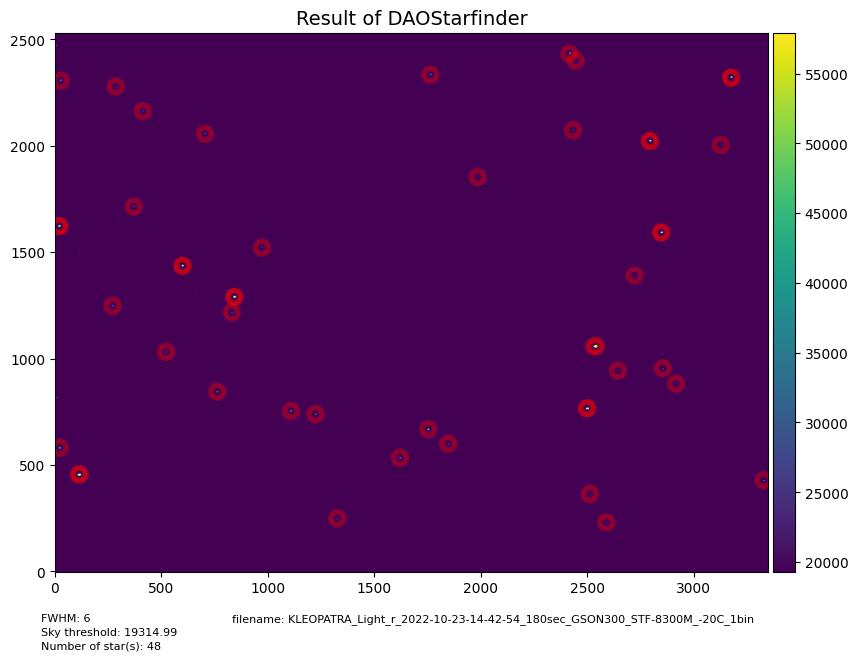

In [24]:
thresh = detect_threshold(data=ccd.data, nsigma=3)
thresh = thresh[0][0]
print('detect_threshold', thresh)

FWHM   = FWHM_INIT

DAOfind = DAOStarFinder(
                        fwhm = FWHM, 
                        threshold = thresh, 
                        sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                        roundlo = -1.0, roundhi = 1.0,  # default values -1 and +1
                        sigma_radius = 1.5,           # default values 1.5
                        ratio = 1.0,                  # 1.0: circular gaussian
                        exclude_border = True         # To exclude sources near edges
                        )
# The DAOStarFinder object ("DAOfind") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
DAOfound = DAOfind(ccd.data)
print('{} star(s) founded by DAOStarFinder...'.format(len(DAOfound)))

#%%
if len(DAOfound)==0 :
    print ('No star was founded by DAOStarFinder...\n'*3)
else : 

    # Use the object "found" for aperture photometry:
    N_stars = len(DAOfound)
    print('{} star(s) founded by DAOStarFinder...'.format(N_stars))
    DAOfound.pprint(max_width=1800)

    #%%
    print('type(DAOfound): {}'.format(type(DAOfound)))
    print('DAOfound: {}'.format(DAOfound))

    DAOcoord = np.array([DAOfound['xcentroid'], DAOfound['ycentroid']]).T
    print('type(DAOcoord): {}'.format(type(DAOcoord)))
    print('DAOcoord: {}'.format(DAOcoord))

    #%%
    # Save apertures as circular, 4 pixel radius, at each (X, Y)
    DAOapert = CAp((DAOcoord), r=4.)  
    print('type(DAOapert): {}'.format(type(DAOapert)))
    print('DAOapert: {}'.format(DAOapert))
    print('dir(DAOapert): {}'.format(dir(DAOapert)))

    DAOannul = CAn(positions = (DAOcoord), r_in = 4*FWHM, r_out = 6*FWHM) 
    print('type(DAOannul): {}'.format(type(DAOannul)))
    print('DAOannul: {}'.format(DAOannul))
    
    #%%
    plt.figure(figsize=(10,7))
    ax = plt.gca()

    im = plt.imshow(ccd.data, 
                    vmin = thresh, 
                    vmax = thresh * 3,
                    #zscale=True,
                    origin='lower'
                    )
    
    DAOannul.plot(color='red', lw=2., alpha=0.4)
    
    ###########################################################
    # input some text for explaination. 
    plt.title("Result of DAOStarfinder", fontsize = 14, 
        ha='center')

    plt.annotate('filename: {}'.format(fpath.stem), fontsize=8,
        xy=(1, 0), xytext=(-10, -30), va='top', ha='right',
        xycoords='axes fraction', textcoords='offset points')
                
    plt.annotate('FWHM: {}'.format(FWHM), fontsize=8,
        xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')
        
    plt.annotate('Sky threshold: {:.02f}'.format(thresh), fontsize=8,
        xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')

    plt.annotate('Number of star(s): {}'.format(len(DAOfound)), fontsize=8,
        xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
        xycoords='axes fraction', textcoords='offset points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.show()
    plt.close() 

Threshold = 6801.97 counts
Found 75 sources
/mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/DAOfinder_result/KLEOPATRA_Light_r_2022-10-23-14-42-54_180sec_GSON300_STF-8300M_-20C_1bin_DAOStarfinder_fwhm_6.csv is created...
/mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/DAOfinder_result/KLEOPATRA_Light_r_2022-10-23-14-42-54_180sec_GSON300_STF-8300M_-20C_1bin_DAOStarfinder_fwhm6.png is created...


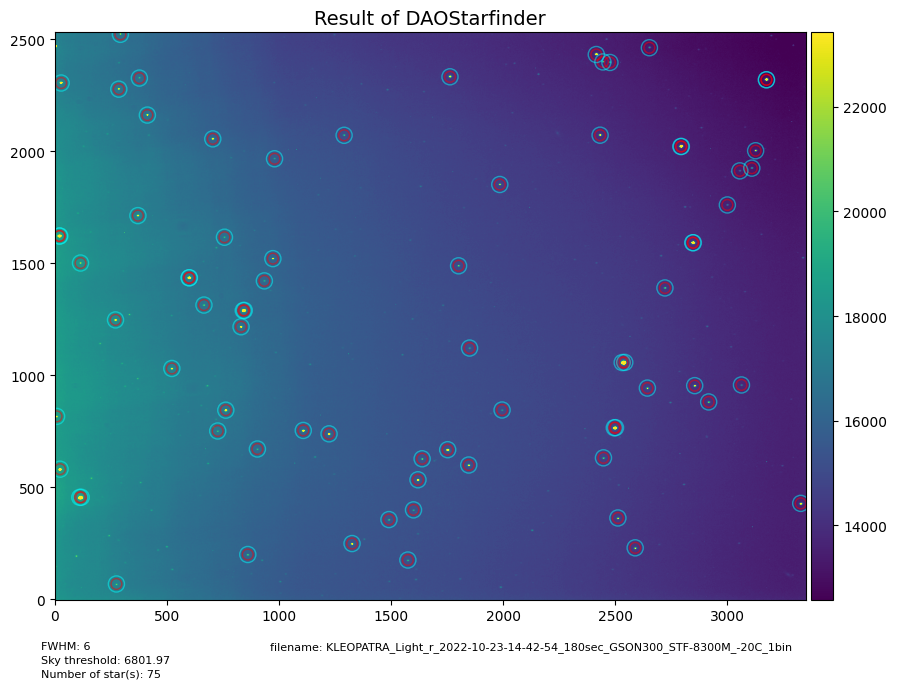

In [29]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
thresh = 5.*std
DAOfind = DAOStarFinder(
                        fwhm = FWHM, 
                        threshold = thresh, 
                        sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                        roundlo = -1.0, roundhi = 1.0,  # default values -1 and +1
                        sigma_radius = 1.5,           # default values 1.5
                        ratio = 1.0,                  # 1.0: circular gaussian
                        exclude_border = True         # To exclude sources near edges
                        )

DAOfound = DAOfind(ccd.data - med)  
DAOfound['RADEC'] = w.pixel_to_world(DAOfound['xcentroid'], 
                    DAOfound['ycentroid'])
print(f"Threshold = {DAOfind.threshold:.2f} counts")
print(f"Found {len(DAOfound)} sources")

# save XY coordinates:
DAOfound.write(f"{DAORESULTDIR}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv",
                overwrite = True,
                format='ascii.fast_csv')
print(f"{DAORESULTDIR}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv is created...")

pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
aps1 = CAp(pos, r=R_IN)
aps2 = CAp(pos, r=R_OUT)
fig, axs = plt.subplots(1, 1, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)

im = vis.norm_imshow(axs, ccd.data, zscale=True)
aps1.plot(color='r', lw=1, alpha=0.5)
aps2.plot(color='cyan', lw=1, alpha=0.5)

###########################################################
# input some text for explaination. 
plt.title("Result of DAOStarfinder", fontsize = 14, 
    ha='center')

plt.annotate(f'filename: {fpath.stem}', fontsize=8,
    xy=(1, 0), xytext=(-10, -30), va='top', ha='right',
    xycoords='axes fraction', textcoords='offset points')
            
plt.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')
    
plt.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.savefig(
            "{}/{}_DAOStarfinder_fwhm{}.png".\
                format(DAORESULTDIR, fpath.stem, FWHM)
            )
print("{}/{}_DAOStarfinder_fwhm{}.png is created...".\
                format(DAORESULTDIR, fpath.stem, FWHM))

plt.show()

In [30]:
print(type(DAOfound))
print(DAOfound['xcentroid'])

<class 'astropy.table.table.QTable'>
    xcentroid     
------------------
274.31321735967674
1575.3565224549172
 860.7835733205271
2589.9214059717715
1326.1351431904307
1490.8535053970606
 2512.875820192523
 1600.489938684119
3329.0932870118686
110.66434649698817
               ...
  284.944178829627
27.470196510136244
3175.5942641138904
3176.3547974209882
376.78489573433984
1763.3407177155082
2477.2550016733308
 2445.986594950039
 2416.361514967256
 2653.521887172838
 292.0520267008102
Length = 75 rows


In [33]:
dir(ccd.wcs)
ccd.wcs.pixel_to_world

<bound method HighLevelWCSMixin.pixel_to_world of WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 340.74259274  3.94596065443  
CRPIX : 1676.5  1266.5  
CD1_1 CD1_2  : 0.000254608662294  4.52030949084e-06  
CD2_1 CD2_2  : -4.52558959506e-06  0.000254697855616  
NAXIS : 3352  2532>

In [62]:
DAOfound['RADEC'] = w.pixel_to_world(DAOfound['xcentroid'], 
                    DAOfound['ycentroid'])
type(DAOfound['RADEC'][0])
print(DAOfound['RADEC'][0])

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (340.38009347, 3.64758496)>


In [52]:
print(type(DAOfound))

astropy.table.table.QTable

In [51]:
print(dir(star_coord))
#star_coord.shape
a = star_coord.to_table
a


['T', '_APPLICABLE_FUNCTIONS', '_METHOD_FUNCTIONS', '__abstractmethods__', '__array_function__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_apply', '_extra_frameattr_names', '_is_name', '_sky_coord_frame', 'altaz', 'apply_space_motion', 'barycentricmeanecliptic', 'barycentrictrueecliptic', 'cache', 'cartesian', 'cirs', 'contained_by', 'copy', 'custombarycentricecliptic', 'cylindrical', 'data', 'dec', 'default_differential', 'default_representation', 'diagonal', 'differential_type', 'directional_offset_by', 'distance', 'equinox', 'fk4', 'fk4noeterms', 'fk5', 'flatten', 'frame', 'frame_attributes', 

<bound method SkyCoord.to_table of <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(340.38009347, 3.64758496), (340.71238455, 3.66881726),
     (340.53016472, 3.67840591), (340.97166851, 3.67789538),
     (340.64907951, 3.68871324), (340.69154895, 3.71521837),
     (340.95252387, 3.7122537 ), (340.71970754, 3.72574489),
     (341.16135746, 3.72496164), (340.33996499, 3.74678912),
     (340.34165496, 3.74687403), (340.72536059, 3.75989404),
     (340.31807739, 3.77919592), (340.7834787 , 3.77564135),
     (340.73046753, 3.78371571), (340.93717061, 3.78099488),
     (340.75978227, 3.79348813), (340.54305093, 3.79817634),
     (340.624947  , 3.8139727 ), (340.49822707, 3.81945237),
     (340.59564367, 3.81835306), (340.95006935, 3.81499596),
     (340.95149919, 3.81507698), (340.31516962, 3.83924988),
     (340.50782936, 3.84295772), (340.82251258, 3.83753279),
     (341.05819986, 3.84239533), (340.98857486, 3.85946283),
     (341.04257396, 3.86123474), (341.09594494, 3.8610452 ),


In [28]:
coord_star = SkyCoord(DAOfound['xcentroid'], 
                    DAOfound['ycentroid'], 
                    )
print(coord_star)

UnitTypeError: Longitude instances require units equivalent to 'rad', but no unit was given.